***Welcome to Medical image processing in Python***<br/>

Presented by: Reza Saadatyar (2024-2025) <br/>
E-mail: Reza.Saadatyar@outlook.com<br/>
**[GitHub](https://github.com/RezaSaadatyar/Deep-Learning-in-python)**

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597)

**Outline:**<br/>
**▪ Importing the dataset**<br/>
**▪ Convert the images into array & masks to binary**<br/>
**▪ RGB to gray**<br/>
**▪ [Image Resizing](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize)**<br/>
**▪ Mask-Based Image Cropping**<br/>
**▪ [Prepare TensorFlow datasets for training, validation, and testing](https://github.com/RezaSaadatyar/Deep-Learning-in-python/blob/main/Code/02_tensorflow_data_loading_and_processing.ipynb)**<br/>
**▪ U-Net Architectur**<br/>

<font color='#FF000e' size="4.8" face="Arial"><b>Importing libraries</b></font>

In [1]:
import os
import sys
import pprint
import numpy as np
from colorama import Fore
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Activation, BatchNormalization

from Functions.image_processor import ImageProcessor
from Functions.prepare_dataset import prepare_dataset
from Functions.filepath_extractor import FilePathExtractor

import importlib

In [92]:
# Check if module is already loaded
if 'Functions.image_processor' in sys.modules:
    importlib.reload(sys.modules['Functions.image_processor'])


<font color=#070bee size="4.5" face="Arial"><b>1️⃣ Importing the dataset</b></font>

In [2]:
# image_path = "D:/Medical-Image-Processing/Data/Inputs/"
image_path = "D:/Medical-Image-Processing/Data/Membrance/images/"

obj = ImageProcessor()

# Read and process images
images = obj.read_images(
    image_path=image_path,
    format_type="png",        # png, tif, jpg
    resize=None,             # Resize to (224, 224)
    normalize=False,         # Normalize to 0-1 range
    to_grayscale=False       # Convert to grayscale
)

Image shape: (30, 512, 512, 1)


In [3]:
# ============================================= Masks to binary ================================================
# mask_path = "D:/Medical-Image-Processing/Data/Masks/"
mask_path = "D:/Medical-Image-Processing/Data/Membrance/masks/"

# With resizing and normalization
masks = obj.read_masks(
    mask_path,
    format_type="png",        # png, TIF, jpg
    resize=None,              # Resize to (224, 224)
    normalize=False           # Normalize if max > 1
)

Detected mask type: Binary based on first mask with 2 unique values
masks.shape = (30, 512, 512, 1)
Total number of classes in masks: 2
Number of 1s (foreground): 6137070
Number of 0s (background): 1727250


In [65]:
output_path = "D:/Medical-Image-Processing/Data/"
# Save the grayscale images
obj.save_grayscale_images(
    images=images,
    output_path=output_path,
    folder_name="Gray image"
)

Images are already grayscale; no conversion or saving needed.


In [4]:
img, mas = obj.crop_images_based_on_masks(images=images, masks=masks)

Cropped 30 image-mask pairs. Output shapes: (30, 512, 512, 1), (30, 512, 512, 1)


In [5]:
# Analyze the final masks array for class counts
unique_classes, class_counts = np.unique(mas, return_counts=True)
num_classes = len(unique_classes)

# # Print mask type and class information
# print(f"Detected mask type: {'Binary' if is_binary else 'Multi-class'} "
#     f"based on first mask with {len(unique_values)} unique values")
print(Fore.GREEN + f"{mas.shape = }")
print(Fore.YELLOW + f"Total number of classes in masks: {num_classes}")
ones_count = np.sum(mas == 1)
zeros_count = np.sum(mas == 0)
print(Fore.YELLOW + f"Number of 1s (foreground): {ones_count}")
print(Fore.YELLOW + f"Number of 0s (background): {zeros_count}")

mas.shape = (30, 512, 512, 1)
Total number of classes in masks: 2
Number of 1s (foreground): 6137070
Number of 0s (background): 1727250


In [42]:
def augmentation(images: np.ndarray, augmente_path: str, num_augmented_images: int, rotation_range: int, 
                 format_type: str = "png") -> None:
    """
    Apply image augmentation (rotation) to image arrays, saving results to disk.

    Args:
    - images (np.ndarray): Input images array of shape [num_images, height, width, channels].
    - augmente_path (str): Base path to create 'augmented' folder with 'images' subfolder.
    - num_augmented_images (int): Number of augmented images to generate per original image.
    - rotation_range (int): Degree range for random image rotation (e.g., 30 for [-30, 30]).
    - format_type (str, optional): File format for saving augmented images (default: "png").

    Notes:
    - Augmented images are saved in `augmente_path/augmented/images/` with prefix 'aug_'.
    - Uses OpenCV for rotation.
    """
    # Validate images array
    if not isinstance(images, np.ndarray) or len(images.shape) != 4:
        raise ValueError("'images' must be a 4D NumPy array (num, h, w, c)")
    
    num_images, height, width, channels = images.shape
    if channels not in [1, 3]:
        raise ValueError(f"Images must have 1 or 3 channels, got {channels}")

    # Create output directories: augmented/images
    img_output_path = os.path.join(augmente_path, "augmented")
    
    os.makedirs(img_output_path, exist_ok=True)

    # Process each image
    for i in range(num_images):
        img = images[i]

        # Handle float inputs by scaling to [0, 255] for OpenCV
        if img.dtype in [np.float32, np.float64] and img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)

        # Generate augmented versions of images only
        for j in range(num_augmented_images):
            # Random rotation angle within range
            angle = np.random.uniform(-rotation_range, rotation_range)
            center = (width // 2, height // 2)
            rot_matrix = cv2.getRotationMatrix2D(center, angle, scale=1.0)

            # Rotate image only
            aug_img = cv2.warpAffine(img, rot_matrix, (width, height), 
                                   flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
            img_filename = os.path.join(img_output_path, f"aug_{i:02d}_{j:02d}.{format_type}")
            cv2.imwrite(img_filename, aug_img)

    total_images = num_images * num_augmented_images
    print(f"Generated and saved {total_images} augmented images to {img_output_path}")

In [43]:
augmente_path= "D:/Medical-Image-Processing/Data/"
augmentation(
    images=images,
    augmente_path=augmente_path,
    num_augmented_images=1,
    rotation_range=30,
    format_type="png"
)

Generated and saved 30 augmented images to D:/Medical-Image-Processing/Data/augmented


In [32]:
output_path="D:/Medical-Image-Processing/Data/augmented/"
masks = generate_mask_from_image(images, method="otsu", output_path=output_path)
# masks = generate_mask_from_image(images, method="threshold", threshold=100, output_path=output_path)

Generated and saved 30 masks to D:/Medical-Image-Processing/Data/augmented/generated_masks


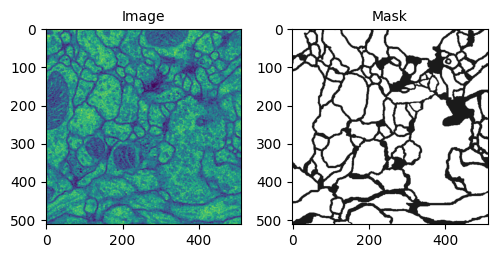

In [66]:
ind = 4 # Set the index of the image and mask to display
plt.figure(figsize=(10, 4))
plt.subplot(141); plt.imshow(images[ind]); plt.title('Image', fontsize=10)
plt.subplot(142); plt.imshow(masks[ind], cmap="gray", alpha=0.9); plt.title('Mask', fontsize=10)
# plt.subplot(143); plt.imshow(data_resize[ind]); plt.title('Image Resizing', fontsize=10)
# plt.subplot(144); plt.imshow(masks_resize[ind], cmap="gray", alpha=0.9); plt.title('Mask Reaizing', fontsize=10)
plt.tight_layout() # Adjust the layout to prevent overlap between subplots

<font color=#ee0caa size="4.5" face="Arial"><b>[Prepare TensorFlow datasets for training, validation, and testing](https://github.com/RezaSaadatyar/Deep-Learning-in-python/blob/main/Code/02_tensorflow_data_loading_and_processing.ipynb)</b></font>

In [17]:
batch_size = 4

# Assuming data_resize and masks_resize are your input data and masks
train_dataset, valid_dataset, test_dataset = prepare_dataset(
    data=data,
    labels=labels,
    train_size=0.7,  
    valid_size=0.15, 
    batch_size=batch_size,
    shuffle_train=True,
    shuffle_buffer_size=1000,
)

Training set:   (20, 512, 512, 1) features, (20, 512, 512, 1) labels
Validation set: (5, 512, 512, 1) features, (5, 512, 512, 1) labels
Test set:       (5, 512, 512, 1) features, (5, 512, 512, 1) labels

Batch size:     4
Training shuffle: enabled
	
(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None))


In [25]:
train_dataset = train_dataset.take(20)
valid_dataset = valid_dataset.take(8)
test_dataset  = test_dataset.take(8)

In [ ]:
# Convert the validation dataset to a list of numpy arrays
list(valid_dataset.as_numpy_iterator())
# or
# Iterate over the first 1 elements of the dataset and print each pair of (x, y) values
for ind_x, ind_y in valid_dataset.take(1):
    # Print the input and output tensors in a formatted string
    print(f"img:\n{ind_x}\nmask:\n{ind_y}")

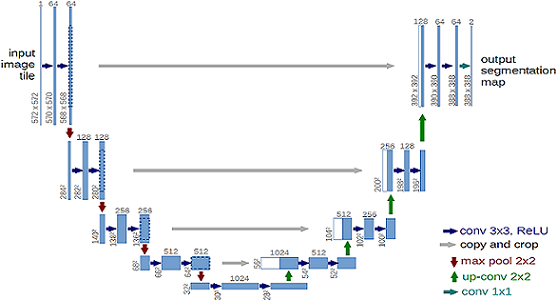 ![unet block.png](<attachment:unet block.png>)
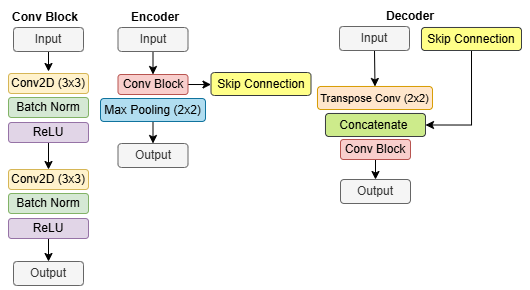

In [19]:
# Calculate class weights based on the imbalance
def compute_class_weights(masks_resize):
    total_pixels = labels.size
    ones_count = np.sum(labels)
    zeros_count = total_pixels - ones_count
    
    # Avoid division by zero
    if ones_count == 0 or zeros_count == 0:
        raise ValueError("Masks contain only one class, cannot compute weights.")
    
    # Weight for class 0 (majority) and class 1 (minority)
    weight_0 = total_pixels / (2.0 * zeros_count)
    weight_1 = total_pixels / (2.0 * ones_count)
    
    return weight_0, weight_1

# Assuming `masks_resize` and `data_resize` are your resized masks and images
weight_0, weight_1 = compute_class_weights(labels)
print(f"Weight for class 0: {weight_0:.4f}, Weight for class 1: {weight_1:.4f}")

Weight for class 0: 2.2765, Weight for class 1: 0.6407


In [20]:
def unet_model(
    img_height: int,
    img_width: int,
    img_channels: int,
    act_dropout: bool = False,
    use_batchnorm: bool = False,
    dropout_rates: dict = {'shallow':0.1, 'mid':0.2, 'deep':0.3},
    n_class:int = 1):
    """
    Args:
        img_height: Height of input images
        img_width: Width of input images
        img_channels: Number of input channels
        act_dropout: Global toggle for dropout (default: False)
        use_batchnorm: Whether to use BatchNormalization (default: False)
        dropout_rates: Dictionary defining dropout rates for different depths
        n_class: Number of output classes (default: 1 for binary segmentation)
    Returns:
        A compiled Keras Model instance
    Example:
        img_height, img_width, img_channels = list(train_dataset.element_spec[0].shape)
         model = unet_model(img_height, img_width, img_channels)
    """

    # Input layer and normalization
    inputs = Input((img_height, img_width, img_channels))
    inputs = Lambda(lambda x: x / 255.0)(inputs)  # Normalize pixel values to [0,1]

    # ======================================= ENCODER (Contracting Path) =======================================
    # Block 1 (Shallow: Lowest Dropout)
    c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(inputs)
    if use_batchnorm: c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
    if use_batchnorm: c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2 (Shallow: Low Dropout)
    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
    if use_batchnorm: c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
    if use_batchnorm: c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    if act_dropout: c2 = Dropout(dropout_rates['shallow'])(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3 (Mid-Depth: Moderate Dropout)
    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
    if use_batchnorm: c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
    if use_batchnorm: c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    if act_dropout: c3 = Dropout(dropout_rates['mid'])(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4 (Mid-Depth: Moderate Dropout)
    c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p3)
    if use_batchnorm: c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
    if use_batchnorm: c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    if act_dropout: c4 = Dropout(dropout_rates['mid'])(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # ======================================= BOTTLENECK (Deepest Layer) =======================================
    c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(p4)
    if use_batchnorm: c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same')(c5)
    if use_batchnorm: c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    if act_dropout: c5 = Dropout(dropout_rates['deep'])(c5)  # Maximum dropout

    # ======================================== DECODER (Expansive Path) ========================================
    # Upsample and concatenate with corresponding encoder features
    up1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    concat1 = concatenate([c4, up1], axis=3)
    c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(concat1)
    if use_batchnorm: c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c6)
    if use_batchnorm: c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    if act_dropout: c6 = Dropout(dropout_rates['mid'])(c6)  # Matches Block 4

    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    concat2 = concatenate([c3, up2], axis=3)
    c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(concat2)
    if use_batchnorm: c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c7)
    if use_batchnorm: c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    if act_dropout: c7 = Dropout(dropout_rates['mid'])(c7)  # Matches Block 3

    up3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    concat3 = concatenate([c2, up3], axis=3)
    c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(concat3)
    if use_batchnorm: c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c8)
    if use_batchnorm: c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    if act_dropout: c8 = Dropout(dropout_rates['shallow'])(c8)  # Matches Block 2

    up4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    concat4 = concatenate([c1, up4], axis=3)
    c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(concat4)
    if use_batchnorm: c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same')(c9)
    if use_batchnorm: c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    # No dropout in final decoder block (shallowest layer)

    # Output layer
    if n_class < 1: raise ValueError("Number of classes must be at least 1")
    act = 'sigmoid' if n_class == 1 else 'softmax'
    c10 = Conv2D(n_class, (1, 1), activation=act)(c9)  # 1x1 conv for output
    
    model = Model(inputs=inputs, outputs=c10)
    return model

In [21]:
# Convert any tf.placeholder usage to tf.compat.v1.placeholder
tf.placeholder = tf.compat.v1.placeholder if hasattr(tf, 'placeholder') else None

img_height, img_width, img_channels = list(train_dataset.element_spec[0].shape[1:])

model = unet_model(img_height, img_width, img_channels, 
                   act_dropout=False,
                   use_batchnorm=False,
                   dropout_rates={'shallow':0.1, 'mid':0.2, 'deep':0.3}  # Custom rates
                  )
# model.summary()

<font color=#ff5478 size="4.5" face="Arial"><b>Segmentation Metrics</b></font><br/>
The selection of the appropriate loss function and metrics for the U-Net model depends on the specifics of the segmentation project (such as binary or multi-class), the characteristics of your dataset (like class imbalance), and your objectives (for instance, prioritizing precision or recall).

**Loss Functions:**<br/>
▪ `binary_crossentropy:` Standard loss for binary classification/segmentation (pixel-wise 0 or 1).<br/>
▪ `metrics['dice_coef_loss']:` 1 - Dice coefficient, emphasizes overlap between predicted and true regions.<br/>
▪ `metrics['iou_coef_loss']:` 1 - IoU, focuses on intersection over union.<br/>
▪ `sparse_categorical_crossentropy:` For multi-class segmentation with integer labels (not one-hot encoded).<br/>

**Metrics:**<br/>
▪ `accuracy:` Proportion of correctly classified pixels (can be misleading for imbalanced data).<br/>
▪ `metrics['dice_coef']:` Measures overlap (2 * intersection / union), ranges from 0 to 1.<br/>
▪ `metrics['iou']:` Intersection over union, ranges from 0 to 1.<br/>
▪ `Recall(): `True positives / (true positives + false negatives), good for detecting all positives.<br/>
▪ `Precision():` True positives / (true positives + false positives), good for reducing false positives.<br/>

🔹 `Dice loss` optimizes the overlap between predicted and true masks, making it crucial for segmentation tasks. It's especially effective for imbalanced datasets, like detecting small tumors in medical imaging, where binary cross-entropy may focus too much on the dominant background class.<br/>
🔹 `Binary cross-entropy` is a simpler and effective choice for pixel-wise classification when the dataset is well-balanced and predictions are confident. However, it is less robust to class imbalances compared to Dice or IoU losses.<br/>
🔹 Use `iou_coef_loss `when the task emphasizes precise region overlap instead of boundary smoothness, such as in object detection-like segmentation. IoU loss serves as an effective alternative to Dice, as it penalizes false positives and negatives differently.<br/>
🔹 The combination of `binary_crossentropy`, which provides pixel-level guidance, and `dice_coef_loss`, which focuses on overall overlap, helps balance local detail with structural fidelity. An initial alpha value of 0.5 is recommended, with adjustments made according to validation results.<br/>

In [23]:
# Custom weighted binary cross-entropy loss function
def weighted_binary_crossentropy(weight_0, weight_1):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)
        
        # Compute binary cross-entropy
        bce = - (weight_1 * y_true * tf.math.log(y_pred) + 
                 weight_0 * (1 - y_true) * tf.math.log(1 - y_pred))
        
        return tf.reduce_mean(bce)
    
    return loss

In [24]:
def segmentation_metrics(alpha: float = 0.5):
    """
    Creates and returns a collection of metrics and loss functions specifically designed for image segmentation tasks.
    Includes implementations of:
    - Dice coefficient (F1 score for segmentation)
    - Dice loss (1 - Dice coefficient)
    - Intersection over Union (IoU/Jaccard index)
    - IoU loss (1 - IoU)
    - Combined loss (binary crossentropy + Dice loss)
    
    All functions are decorated with @tf.function for optimized TensorFlow graph execution and include numerical 
    stability smoothing (epsilon value).
    
    Example:
    - adam = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False) # Or 'adam', 'rmsprop'
    - loss=metrics['combined_loss'], # Or binary_crossentropy, 'sparse_categorical_crossentropy', metrics['dice_coef_loss'], 'iou_coef_loss', 'combined_loss'
    - metrics = segmentation_metrics(alpha=0.2)
    - model.compile(optimizer=adam, loss=metrics['combined_loss'], metrics=['accuracy',
        metrics['dice_coef'], metrics['iou'], tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
    run_eagerly=False),  # Set run_eagerly=False for better performance
    
    Returns: 
    - dict: A dictionary containing five callable metric/loss functions:
      - 'dice_coef': Dice coefficient metric; Higher is better (range 0-1)
      - 'dice_coef_loss': Dice loss function; Lower is better (range 0-1)
      - 'iou': IoU metric; Higher is better (range 0-1)
      - 'iou_coef_loss': IoU loss function; Lower is better (range 0-1)
      - 'combined_loss': Combined BCE + Dice loss; Lower is better
    """
    # Small constant to prevent division by zero and ensure numerical stability
    smooth = 1e-15
    
    @tf.function
    def dice_coef(y_true, y_pred):
        """
        Computes the Dice coefficient (F1 score) between ground truth and predicted masks.
        
        The Dice coefficient measures the overlap between two samples, with values ranging
        from 0 (no overlap) to 1 (perfect overlap). Defined as:
        Dice = (2 * |X ∩ Y|) / (|X| + |Y|)
        
        Args:
        - y_true: Ground truth masks (tensor of shape [batch_size, height, width, channels])
        - y_pred: Predicted probability masks (tensor of same shape as y_true)
        
        Returns:
            Tensor: Scalar Dice coefficient value
        """
        # # Ensure tensors are float32 for consistent computation
        # y_true = tf.cast(y_true, tf.float32)
        # y_pred = tf.cast(y_pred, tf.float32)
        
        # # Compute intersection (element-wise multiplication followed by sum)
        # intersection = tf.reduce_sum(y_true * y_pred)
        # # Compute union (sum of individual masks)
        # union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
        # # Calculate Dice coefficient with smoothing factor
        # return (2. * intersection + smooth) / (union + smooth)

        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

    @tf.function
    def dice_coef_loss(y_true, y_pred):
        """
        Computes Dice loss as 1 - Dice coefficient.
        
        This loss function is commonly used in segmentation tasks where the target
        is to maximize the Dice coefficient. The loss ranges from 0 (perfect match)
        to 1 (no overlap).
        
        Args:
        - y_true: Ground truth masks (tensor)
        - y_pred: Predicted masks (tensor)
        
        Returns:
            Tensor: Scalar Dice loss value
        """
        return 1.0 - dice_coef(y_true, y_pred)

    @tf.function
    def iou(y_true, y_pred):
        """
        Computes Intersection over Union (IoU/Jaccard index) between masks.
        
        IoU measures the overlap between two samples, with values ranging from
        0 (no overlap) to 1 (perfect overlap). Defined as:
        IoU = |X ∩ Y| / |X ∪ Y|
        
        Args:
        - y_true: Ground truth masks (tensor)
        - y_pred: Predicted masks (tensor)
        
        Returns:
            Tensor: Scalar IoU value
        """
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
        # # Ensure tensors are float32 for consistent computation
        # y_true = tf.cast(y_true, tf.float32)
        # y_pred = tf.cast(y_pred, tf.float32)
        
        # # Compute intersection
        # intersection = tf.reduce_sum(y_true * y_pred)
        # # Compute total area covered by both masks
        # total = tf.reduce_sum(y_true + y_pred)
        # # Compute union (total area minus intersection)
        # union = total - intersection
        # Calculate IoU with smoothing factor
        return (intersection + smooth) / (union + smooth)

    @tf.function
    def iou_coef_loss(y_true, y_pred):
        """
        Computes IoU loss as 1 - IoU.
        
        This loss function is used in segmentation tasks where the target is to
        maximize the IoU metric. The loss ranges from 0 (perfect match) to 1
        (no overlap).
        
        Args:
        - y_true: Ground truth masks (tensor)
        - y_pred: Predicted masks (tensor)
        
        Returns:
            Tensor: Scalar IoU loss value
        """
        return 1.0 - iou(y_true, y_pred)

    @tf.function
    def combined_loss(y_true, y_pred):
        """
        Computes a combined loss of binary crossentropy and Dice loss.
        
        This hybrid loss balances pixel-wise classification (BCE) with region overlap (Dice).
        The weighting factor alpha controls the contribution of each component:
        - Loss = alpha * BCE + (1 - alpha) * Dice_loss
        
        Args:
        - y_true: Ground truth masks (tensor)
        - y_pred: Predicted masks (tensor)
        - alpha: Weighting factor between BCE and Dice loss (default: 0.5)
        
        Returns:
            Tensor: Scalar combined loss value
        """
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice = dice_coef_loss(y_true, y_pred)
        return alpha * bce + (1 - alpha) * dice

    # Return all functions in a dictionary for easy access
    return {
        'dice_coef': dice_coef,            # Metric: Higher is better (range 0-1)
        'dice_coef_loss': dice_coef_loss,  # Loss: Lower is better (range 0-1)
        'iou': iou,                        # Metric: Higher is better (range 0-1)
        'iou_coef_loss': iou_coef_loss,    # Loss: Lower is better (range 0-1)
        'combined_loss': combined_loss     # Loss: Lower is better
    }

In [25]:
metrics = segmentation_metrics(alpha=0.1)

adam = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)
# Compile the model with custom loss and metrics
model.compile(
    optimizer=adam,             # Or 'adam', 'rmsprop'
    loss=weighted_binary_crossentropy(weight_0, weight_1),
    # loss=metrics['dice_coef_loss'], # Or binary_crossentropy, 'sparse_categorical_crossentropy', metrics['dice_coef_loss'], 'iou_coef_loss', 'combined_loss'
    metrics=[
        'accuracy',
        metrics['combined_loss'],
        metrics['iou'],
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.MeanIoU(num_classes=2),
        ],
    run_eagerly=False,  # Set run_eagerly=False for better performance
    )


<font color=#hh5458 size="4.5" face="Arial"><b>Callbacks</b></font><br/>
`EarlyStopping`<br/>
▪ Stops training if `val_loss` doesn’t improve for 5 epochs.<br/>
▪ Keeps final weights (not best) when stopping.<br/>
▪ Prevents overfitting, saves time.<br/>

`CSVLogger(csv_path)`<br/>
▪ Logs all metrics (e.g., loss, accuracy) to a CSV file each epoch.<br/>
▪ Creates a persistent record for analysis.<br/>
▪ Track progress, analyze later.<br/>

`ModelCheckpoint`<br/>
▪ Saves the model to a file when `val_loss` improves.<br/>
▪ Only saves the best model (overwrites previous saves).<br/>
▪ Preserves the best model state.<br/>

`ReduceLROnPlateau`<br/>
▪ Reduces learning rate by 10x (e.g., 1e-4 to 1e-5) if `val_loss` stalls for 5 epochs.<br/>
▪ Won’t go below 1e-7; prints updates.<br/>
▪ Helps fine-tune when training plateaus.<br/>

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

class ImageDisplayCallback(keras.callbacks.Callback):
    """
    Custom callback to display input image, ground truth mask, and predicted mask
    for a specific sample at the beginning of the first epoch and end of the last epoch.
    """
    
    def __init__(self, dataset, sample_idx=0):
        """
        Args:
            dataset: tf.data.Dataset object containing (image, mask) pairs
            sample_idx: Index of the sample to display from the dataset (default: 0)
        """
        super().__init__()
        self.dataset = dataset
        self.sample_idx = sample_idx
        self.num_epochs = None  # Will be set during training
        
    def on_train_begin(self, logs=None):
        """Get the total number of epochs from the training configuration."""
        self.num_epochs = self.params['epochs']
        
    def on_epoch_begin(self, epoch, logs=None):
        """Display images at the beginning of the first epoch (epoch 0)."""
        if epoch == 0:
            self._display_images(epoch, "First Epoch Begin")
            
    def on_epoch_end(self, epoch, logs=None):
        """Display images at the end of the last epoch."""
        if epoch == self.num_epochs - 1:
            self._display_images(epoch, "Last Epoch End")
            
    def _display_images(self, epoch, title_prefix):
        """Helper function to display input image, ground truth mask, and prediction."""
        # Get a batch from the dataset and select the specified sample
        for batch in self.dataset.take(1):  # Take the first batch
            images, masks = batch
            img = images[self.sample_idx].numpy()  # Convert to NumPy
            mask = masks[self.sample_idx].numpy()  # Convert to NumPy
            
            # Predict using the model
            pred = self.model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
            
            # Create a figure with 3 subplots
            plt.figure(figsize=(10, 4))
            
            # Input Image
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f"{title_prefix} - Input Image")
            plt.axis('off')
            
            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(np.squeeze(mask), cmap='gray')
            plt.title(f"{title_prefix} - Ground Truth Mask")
            plt.axis('off')
            
            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(np.squeeze(pred), cmap='gray')
            plt.title(f"{title_prefix} - Predicted Mask")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

In [27]:
# Define the callbacks
# csv_path = os.path.join("files", "log.csv")
csv_path = 'training_log.csv'  # File to log training metrics
model_checkpoint_path = 'model.keras'  # File to save the best model

callbacks = [
    CSVLogger(csv_path),  # Logs metrics to a CSV file
    ImageDisplayCallback(train_dataset, sample_idx=0),  # Show the first sample in the batch
    ModelCheckpoint(
        filepath=model_checkpoint_path,
        monitor='val_loss',  # Monitor validation loss
        verbose=1,           # Print when saving
        save_best_only=True  # Save only when val_loss improves
    ),
    ReduceLROnPlateau(
        monitor='val_loss',  # Monitor validation loss
        factor=0.1,          # Reduce learning rate by 10x
        patience=5,          # Wait 5 epochs without improvement
        min_lr=1e-7,         # Minimum learning rate
        verbose=1            # Print when reducing LR
    ),
    EarlyStopping(
        monitor='val_loss',        # Monitor validation loss
        patience=5,                # Stop after 5 epochs without improvement
        restore_best_weights=True  # Restore best weights (changed to True for better results)
    )
]

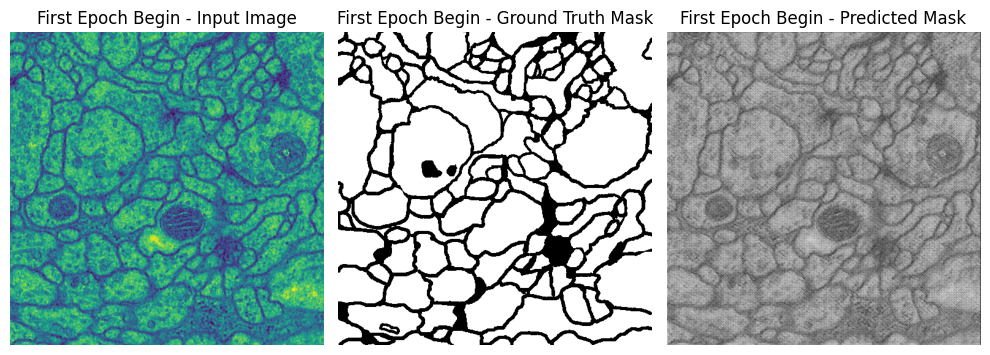

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6975 - combined_loss: 0.3576 - iou: 0.5055 - loss: 0.7016 - mean_io_u: 0.1139 - precision: 0.7807 - recall: 0.8481
Epoch 1: val_loss improved from inf to 0.65278, saving model to model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 78s 12s/step - accuracy: 0.7004 - combined_loss: 0.3589 - iou: 0.5040 - loss: 0.6986 - mean_io_u: 0.1133 - precision: 0.7828 - recall: 0.8497 - val_accuracy: 0.7886 - val_combined_loss: 0.3337 - val_iou: 0.5327 - val_loss: 0.6528 - val_mean_io_u: 0.1093 - val_precision: 0.7979 - val_recall: 0.9771 - learning_rate: 0.0010
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7852 - combined_loss: 0.3368 - iou: 0.5255 - loss: 0.6545 - mean_io_u: 0.1110 - precision: 0.8035 - recall: 0.9588
Epoch 2: val_loss improved from 0.65278 to 0.60723, saving model to model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.7855 - combined_loss: 0.3371 - iou: 0.5251 - loss: 0.6529 - mean_io_u: 0.1110 - precision: 0.

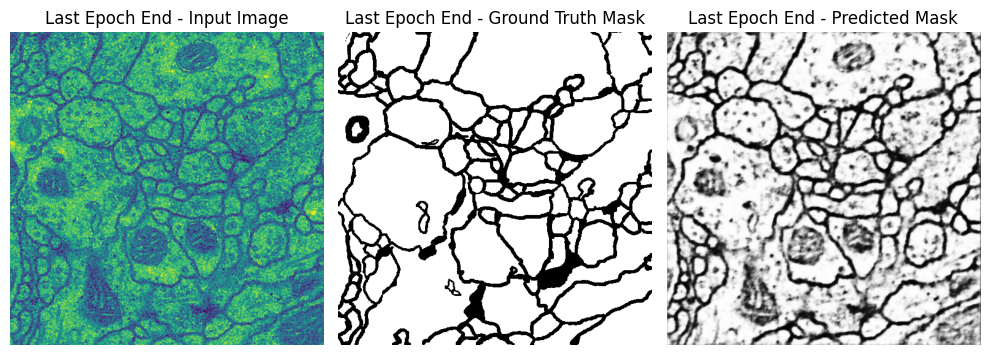


Epoch 10: val_loss did not improve from 0.37339
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 11s/step - accuracy: 0.8081 - combined_loss: 0.2079 - iou: 0.6886 - loss: 0.3882 - mean_io_u: 0.1116 - precision: 0.9483 - recall: 0.7965 - val_accuracy: 0.8514 - val_combined_loss: 0.1598 - val_iou: 0.7629 - val_loss: 0.3758 - val_mean_io_u: 0.1093 - val_precision: 0.9350 - val_recall: 0.8704 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8351 - combined_loss: 0.1854 - iou: 0.7239 - loss: 0.3581 - mean_io_u: 0.1083 - precision: 0.9503 - recall: 0.8330


In [28]:
# Train the model
# Hyperparameters
num_epochs = 10
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    callbacks=callbacks,
    validation_data=valid_dataset,
    shuffle=False,
    verbose=1,
)
# Evaluate on test set
results = model.evaluate(test_dataset, return_dict=True)
# print(f"Test Dice Coefficient: {results['dice_coef']:.4f}")
# print(f"Test IoU: {results['iou']:.4f}")
# print(f"Test Recall: {results['recall']:.4f}")
# print(f"Test Precision: {results['precision']:.4f}")
# print(f"Test Loss: {results['loss']:.4f}")

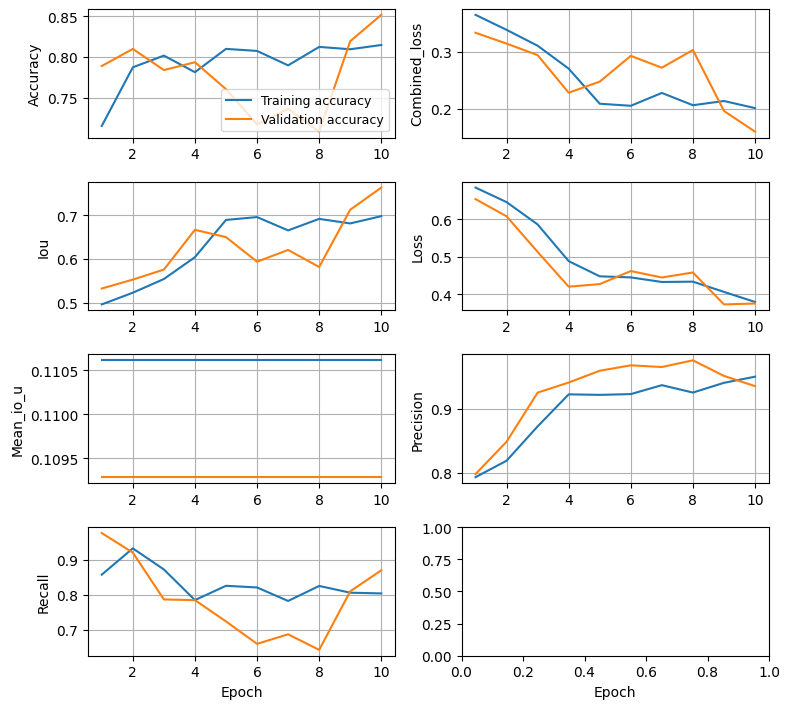

In [29]:
def plot_training_history(history):
    """
    Plot training and validation metrics/loss over epochs based on available metrics in history.
    
    Args:
    - history: History object from model.fit()
    """
    # Get metrics with both training and validation versions
    metrics_to_plot = [m for m in history.history if not m.startswith('val_') and f'val_{m}' in history.history]
   
    # If no metrics found, raise an error
    if not metrics_to_plot: raise ValueError("No valid metrics found in history to plot.")
    
    # Define epochs range
    epochs = range(1, len(history.history['loss']) + 1)

    # Create subplots dynamically based on number of metrics
    n_metrics = len(metrics_to_plot)
    n_rows = (n_metrics + 1) // 2  # Ceiling division to determine rows
    n_cols = min(n_metrics, 2)     # Max 2 columns
    
    plt.figure(figsize=(8, 1.8 * n_rows))  # Adjust height based on number of rows
    
    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(n_rows, n_cols, i)
        plt.plot(epochs, history.history[metric], label=f'Training {metric}')
        plt.plot(epochs, history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.ylabel(metric.capitalize(), fontsize=10)
        if i == 1: plt.legend(fontsize=9)
        plt.grid(True)
    
    # Add xlabel only to the bottom row
    for i in range(n_rows * n_cols - n_cols + 1, n_rows * n_cols + 1):
        plt.subplot(n_rows, n_cols, i)
        plt.xlabel('Epoch', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Plot the history
plot_training_history(history)

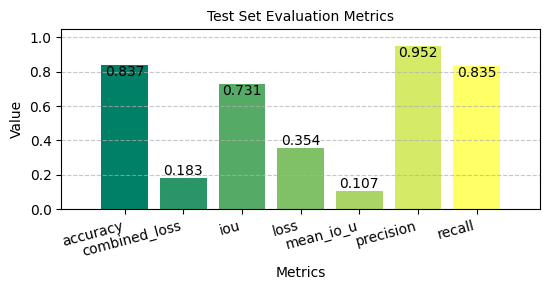

In [30]:
def plot_test_results(results):
    """
    Plot test set evaluation results as a bar chart based on available metrics in results.
    
    Args:
    - results: Dictionary from model.evaluate(return_dict=True)
    """
    # Extract all metrics from the results dictionary
    metrics_to_plot = list(results.keys())
    
    # If no metrics found, raise an error
    if not metrics_to_plot: raise ValueError("No metrics found in results to plot.")
    
    # Create bar plot with dynamic width and assigned colors
    plt.figure(figsize=(max(4, len(metrics_to_plot) * 0.8), 3))
    
    # Get corresponding values
    values = [results[metric] for metric in metrics_to_plot]
    
    # Define a color map and assign colors to each bar
    colors = plt.cm.summer(np.linspace(0, 1, len(metrics_to_plot)))
    bars = plt.bar(metrics_to_plot, values, color=colors)
    
    # Add value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', 
                 ha='center', va='bottom' if yval < 0.5 else 'top', color='black', rotation=0)
    
    plt.margins(x=0.1)
    plt.ylabel('Value', fontsize=10)
    plt.xticks(rotation=15, ha='right')
    plt.ylim(0, max(1.0, max(values) * 1.1))  # Adjust y-axis for visibility
    plt.xlabel('Metrics', fontsize=10, labelpad=5)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.title('Test Set Evaluation Metrics', fontsize=10)
    plt.tight_layout()
    plt.show()

# Plot the results
plot_test_results(results)